In [2]:
from huggingface_hub import hf_hub_download
import huggingface_hub as hf
import pickle
from pprint import pprint
import os
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_from_disk

/home/krrish/Desktop/Programming/geneformer-scratch/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Working with the datasets

In [4]:
MAIN_DATA = "data/genecorpus_30M_2048.dataset/dataset.arrow"
TOKEN_DICT = "data/token_dictionary.pkl"
SORTED_LENGTH = "data/genecorpus_30M_2048_sorted_lengths.pkl"
LENGTH = "data/genecorpus_30M_2048_lengths.pkl"
MAIN_PATH = "/home/krrish/Desktop/Programming/geneformer-scratch/"

In [5]:
# Load and inspect token dictionary
token_dict_path = os.path.join(MAIN_PATH, TOKEN_DICT)
with open(token_dict_path, "rb") as f:
    token_dict = pickle.load(f)

print("Token Dictionary:")
print(f"Type: {type(token_dict)}")
print(f"Length: {len(token_dict)}")
print("\nFirst 20 items:")
pprint(list(token_dict.items())[:20])

# Load and inspect lengths
lengths_path = os.path.join(MAIN_PATH, LENGTH)
with open(lengths_path, "rb") as f:
    lengths = pickle.load(f)

print("\n\nLengths:")
print(f"Type: {type(lengths)}")
print(f"Length: {len(lengths)}")
print(f"First 20 values: {lengths[:20]}")

# Load and inspect sorted lengths
sorted_length_path = os.path.join(MAIN_PATH, SORTED_LENGTH)
with open(sorted_length_path, "rb") as f:
    sorted_lengths = pickle.load(f)

print("\n\nSorted Lengths:")
print(f"Type: {type(sorted_lengths)}")
print(f"Length: {len(sorted_lengths)}")
print(f"First 20 values: {sorted_lengths[:20]}")

Token Dictionary:
Type: <class 'dict'>
Length: 25426

First 20 items:
[('<pad>', 0),
 ('<mask>', 1),
 ('ENSG00000000003', np.int16(2)),
 ('ENSG00000000005', np.int16(3)),
 ('ENSG00000000419', np.int16(4)),
 ('ENSG00000000457', np.int16(5)),
 ('ENSG00000000460', np.int16(6)),
 ('ENSG00000000938', np.int16(7)),
 ('ENSG00000000971', np.int16(8)),
 ('ENSG00000001036', np.int16(9)),
 ('ENSG00000001084', np.int16(10)),
 ('ENSG00000001167', np.int16(11)),
 ('ENSG00000001460', np.int16(12)),
 ('ENSG00000001461', np.int16(13)),
 ('ENSG00000001497', np.int16(14)),
 ('ENSG00000001561', np.int16(15)),
 ('ENSG00000001617', np.int16(16)),
 ('ENSG00000001626', np.int16(17)),
 ('ENSG00000001629', np.int16(18)),
 ('ENSG00000001630', np.int16(19))]


Lengths:
Type: <class 'list'>
Length: 27406216
First 20 values: [2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 2048]


Sorted Lengths:
Type: <class 'list'>
Length: 27406216
First 20 values:

In [7]:
# Optimizing the dataloader is going to be a big thing. Need to figure out the datatype. 

vocab_size = len(token_dict)
max_token_id = max(token_dict.values())

print(f"\nDtype requirements:")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Max token ID: {max_token_id:,}")


Dtype requirements:
  Vocab size: 25,426
  Max token ID: 25,425


We are going to use `int16` for everything. Just while calculating the embeddings need to be careful. 

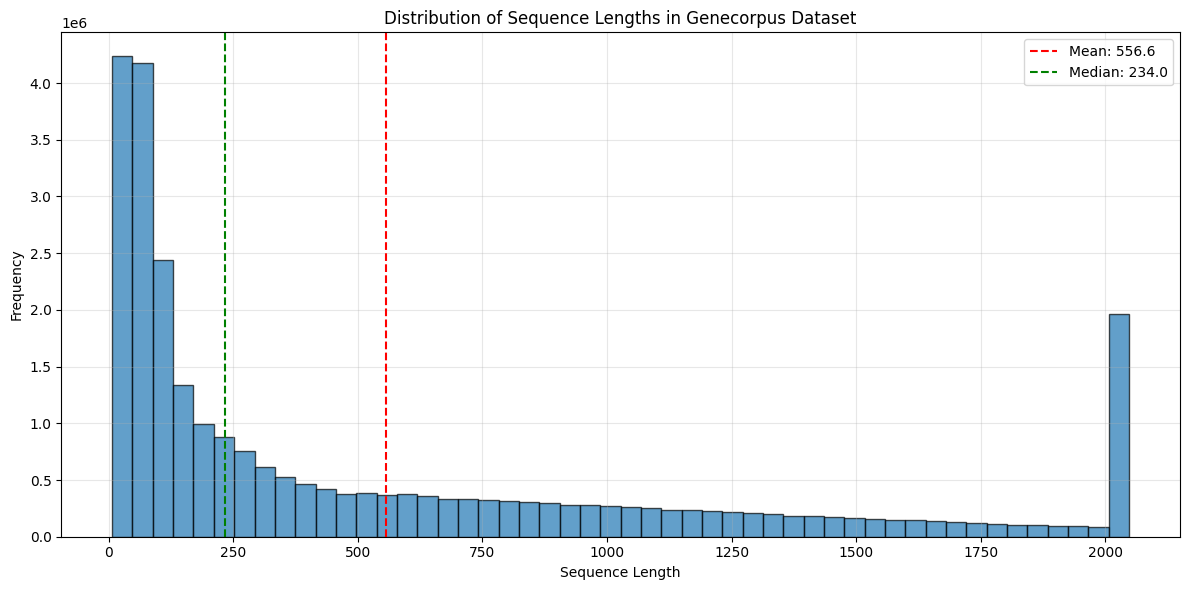

Sequence Length Statistics:
  Min: 7
  Max: 2048
  Mean: 556.56
  Median: 234.00
  Std Dev: 639.62
  25th percentile: 74.00
  75th percentile: 897.00
  95th percentile: 2048.00
  99th percentile: 2048.00


In [15]:
# Create histogram of sequence lengths
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in Genecorpus Dataset')
plt.grid(True, alpha=0.3)

# Add statistics
mean_len = np.mean(lengths)
median_len = np.median(lengths)
max_len = np.max(lengths)
min_len = np.min(lengths)

plt.axvline(mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.1f}')
plt.axvline(median_len, color='green', linestyle='--', label=f'Median: {median_len:.1f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"Sequence Length Statistics:")
print(f"  Min: {min_len}")
print(f"  Max: {max_len}")
print(f"  Mean: {mean_len:.2f}")
print(f"  Median: {median_len:.2f}")
print(f"  Std Dev: {np.std(lengths):.2f}")
print(f"  25th percentile: {np.percentile(lengths, 25):.2f}")
print(f"  75th percentile: {np.percentile(lengths, 75):.2f}")
print(f"  95th percentile: {np.percentile(lengths, 95):.2f}")
print(f"  99th percentile: {np.percentile(lengths, 99):.2f}")

In [9]:
total_computations = len(lengths) * (2048**2)
total_pad_computations = np.sum((2048 - np.array(lengths))**2)

print(f"Total computations without grouping: {total_computations:,}")
print(f"Total padding computations: {total_pad_computations:,}")
print(f"Padding overhead: {(total_pad_computations/total_computations)*100:.2f}%")

Total computations without grouping: 114,950,001,393,664
Total padding computations: 72,174,660,304,770
Padding overhead: 62.79%


So essentially 62.79% of the computation is being gone to the padding related computations. Haha, this neccessites the createion of length grouped sampler.

In [ ]:
# Load the entire dataset folder
dataset_path = os.path.join(MAIN_PATH, "data/genecorpus_30M_2048.dataset")
ds = load_from_disk(dataset_path)

print("Dataset Info:")
print(f"Number of rows: {len(ds)}")
print(f"Columns: {ds.column_names}")
print(f"Features:\n{ds.features}")

print("\n\nFirst single example:")
pprint(ds[0], compact=True)

Dataset Info:
Number of rows: 27406216
Columns: ['input_ids', 'length']
Features:
{'input_ids': List(Value('int16')), 'length': Value('int16')}


First single example:
{'input_ids': [11143, 17261, 5368, 7411, 16411, 16337, 18754, 7055, 3906, 2109,
               10837, 8323, 1101, 6927, 18526, 2315, 9462, 3318, 3777, 12039,
               8877, 8008, 6840, 3932, 13443, 2359, 13693, 1823, 6533, 1981,
               16536, 11457, 18369, 15243, 13193, 17911, 5647, 2271, 14797,
               4326, 20334, 454, 10658, 17906, 11572, 955, 4163, 4422, 2786,
               8953, 15447, 14679, 10282, 13128, 11727, 16481, 17224, 1850,
               8462, 13590, 4703, 13569, 2961, 15255, 3101, 16472, 12926, 9724,
               20356, 3826, 3917, 5267, 1513, 15699, 3606, 9561, 6566, 5343,
               15937, 11938, 7203, 16990, 13620, 12437, 13643, 12040, 2100,
               13257, 5910, 576, 7502, 12324, 12636, 12460, 9220, 6423, 10863,
               5212, 13735, 24512, 4686, 2061, 5538, 479

Okay so they have given us the input id's and lengths and the data set is already tokenized and ranked we just need to figure out a way to just build a tokenizer which implements lengths grouped padding and distills the model. Just that not much. 

# int64 to int16

We are doing this conversion because all the values are under the limits of `int16`

from `int64` to `int16` we compress the data from around _120GB_ to _35GB_

In [16]:
# Simple int16 conversion
from datasets import Features, Value, Sequence

# Define int16 features
new_features = Features({
    'input_ids': Sequence(Value('int16')),
    'length': Value('int16')
})

# Convert dataset
print("Converting to int16...")
ds_int16 = ds.cast(new_features)

# Save
output_path = os.path.join(MAIN_PATH, "data/genecorpus_30M_2048_int16.dataset")
ds_int16.save_to_disk(output_path, num_shards=1)

print(f"✅ Saved to: {output_path}")
print(f"Original: {ds.features}")
print(f"New: {ds_int16.features}")

Converting to int16...


Saving the dataset (1/1 shards): 100%|██████████| 27406216/27406216 [01:07<00:00, 406747.49 examples/s] 

✅ Saved to: /home/krrish/Desktop/Programming/geneformer-scratch/data/genecorpus_30M_2048_int16.dataset
Original: {'input_ids': List(Value('int64')), 'length': Value('int64')}
New: {'input_ids': List(Value('int16')), 'length': Value('int16')}
